In [6]:
from pathlib import Path
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm
import subprocess


data_dir = './annotations/summit/optimisation'


In [19]:
combined_df = pd.concat(
    [
        pd.read_csv(f)
        for f in Path(data_dir).iterdir() if
        f.name.endswith('metadata.csv')
    ]
)

labels = combined_df.rename(
    columns={
        'seriesuid' : 'scan_id',
        'coordX' : 'row',
        'coordY' : 'col',
        'coordZ' : 'idx',
        'diameter_mm' : 'diameter'
    })

labels.head()


,scan_id,row,col,idx,diameter
0,summit-2227-pjw_Y0_BASELINE_A,295.78,87.85,74.170,5.0
1,summit-2227-zzp_Y0_BASELINE_A,135.35,125.41,134.940,5.6
2,summit-2227-zzp_Y0_BASELINE_A,70.87,172.37,76.200,8.2
3,summit-2234-kvj_Y0_BASELINE_A,272.37,138.05,108.190,4.8
4,summit-2257-hrd_Y0_BASELINE_A,196.87,172.88,275.275,4.7


In [20]:
import SimpleITK as sitk
from matplotlib import pyplot as plt
import os

workspace = Path(os.getcwd()).parent.parent

def copy_scan_from_cluster(scan_id, workspace):
    study_id = scan_id.split('_')[0]
   # now copy the src file
    if not os.path.exists(f"{workspace}/data/summit/scans/{study_id}/{scan_id}.mhd"):
        os.makedirs(f"{workspace}/data/summit/scans/{study_id}", exist_ok=True)

        command = [
            "scp",
            "-P 2222",
            f"jmccabe@localhost:/cluster/project2/SummitLung50/{study_id}/{scan_id}.*",
            f"{workspace}/data/summit/scans/{study_id}/."
        ]
        result = subprocess.run(command)
        print(result.stdout)
    else:
        print(f'{scan_id} already exists')

def read_mhd(file_path):
    itk_image = sitk.ReadImage(file_path)
    scan = sitk.GetArrayFromImage(itk_image)
    return scan, itk_image.GetSpacing(), itk_image.GetDirection(), itk_image.GetOrigin()

def show_nodule(scan_id, x, y, z, d, workspace):
    scan, spacing, orientation, origin = read_mhd(f"{workspace}/data/summit/scans/{scan_id.split('_')[0]}/{scan_id}.mhd")

    print(spacing)

    # Convert x, y, z to row, col, index
    row = int((x - origin[0]) / spacing[0])
    col = int((y - origin[1]) / spacing[1])
    idx = int((z - origin[2]) / spacing[2])

    print(f'{scan_id} - x: {x}, y: {y}, z: {z}, d: {d} / row: {row}, col: {col}, idx: {idx}, scan shape: {scan.shape}')
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(scan[idx,:,:], cmap='gray')
    circle = plt.Circle((row, col), d, color='r', fill=False)
    ax.add_artist(circle)
    plt.show()


In [26]:
# Check if any labels have negative values

metadata = (
    pd.concat([
        pd.read_csv(f'{workspace}/metadata/summit/optimisation/{ds}_metadata.csv', usecols=['scan_id','nodule_x_coordinate', 'nodule_y_coordinate', 'nodule_z_coordinate', 'nodule_diameter_mm'])
        for ds in ['training', 'validation', 'test', 'holdout']
    ])
)

shapes = (
    pd.read_csv('./annotations/summit/optimisation/shapes.csv')
    .rename(columns={'Unnamed: 0' : 'scan_id', '0': 'idx_dim', '1': 'row_dim', '2': 'col_dim'})
)

qc_data = (
    pd.merge(labels, shapes, on='scan_id')
    .assign(row_diff=lambda df: df.row.astype(int) - df.row_dim)
    .assign(col_diff=lambda df: df.col.astype(int) - df.col_dim)
    .assign(idx_diff=lambda df: df.idx.astype(int) - df.idx_dim)
)

nodules_outside_scan_dims = qc_data.query('row_diff > 0 | col_diff > 0 | idx_diff > 0')

negative_labels = qc_data.query('row < 0 | col < 0 | idx < 0')

display(metadata.head(5))
display(nodules_outside_scan_dims)
display(negative_labels)

,nodule_diameter_mm,nodule_x_coordinate,nodule_y_coordinate,nodule_z_coordinate,scan_id
0,7.6,73.05,56.84,-190.33,summit-2222-djr_Y0_BASELINE_A
1,10.0,58.76,61.71,-187.04,summit-2222-djr_Y0_BASELINE_A
2,4.8,-92.18,-51.99,-230.21,summit-2222-djr_Y0_BASELINE_A
3,6.1,57.64,2.88,-178.43,summit-2225-stn_Y0_BASELINE_A
4,3.7,-81.66,-72.17,-186.41,summit-2225-stn_Y0_BASELINE_A


,scan_id,row,col,idx,diameter,idx_dim,row_dim,col_dim,row_diff,col_diff,idx_diff
0,summit-2227-pjw_Y0_BASELINE_A,295.78,87.85,74.170,5.0,306,209,305,86,-218,-232
3,summit-2234-kvj_Y0_BASELINE_A,272.37,138.05,108.190,4.8,281,232,299,40,-161,-173
6,summit-2276-nzk_Y0_BASELINE_A,267.54,133.10,256.290,11.4,291,239,350,28,-217,-35
11,summit-2276-phv_Y0_BASELINE_A,249.66,96.27,86.220,6.2,274,196,270,53,-174,-188
12,summit-2276-phv_Y0_BASELINE_A,235.23,97.39,90.280,3.8,274,196,270,39,-173,-184
...,...,...,...,...,...,...,...,...,...,...,...
10392,summit-9956-wef_Y0_BASELINE_A,303.08,177.99,83.515,4.1,291,247,339,56,-162,-208
10394,summit-9956-wef_Y0_BASELINE_A,255.54,105.69,206.275,6.7,291,247,339,8,-234,-85
10395,summit-9956-wef_Y0_BASELINE_A,269.68,216.16,111.685,5.4,291,247,339,22,-123,-180
10407,summit-9987-jyy_Y0_BASELINE_A,217.33,119.20,60.270,13.8,260,216,258,1,-139,-200


,scan_id,row,col,idx,diameter,idx_dim,row_dim,col_dim,row_diff,col_diff,idx_diff
4182,summit-5628-vrn_Y0_BASELINE_A,234.8,157.38,-40.37,0.0,293,227,310,7,-153,-333


summit-9754-pkv_Y0_BASELINE_A not found in metadata
summit-8935-guu_Y0_BASELINE_A not found in metadata
summit-3399-wdd_Y0_BASELINE_A already exists
(0.652344, 0.652344, 0.625)
summit-3399-wdd_Y0_BASELINE_A - x: 76.65, y: 22.31, z: -119.74, d: 4.8 / row: 385, col: 290, idx: 211, scan shape: (420, 512, 512)


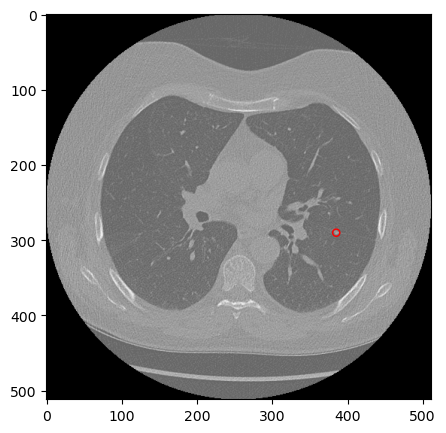

summit-3399-wdd_Y0_BASELINE_A already exists
(0.652344, 0.652344, 0.625)
summit-3399-wdd_Y0_BASELINE_A - x: -52.11, y: 48.76, z: -28.95, d: 4.6 / row: 188, col: 330, idx: 356, scan shape: (420, 512, 512)


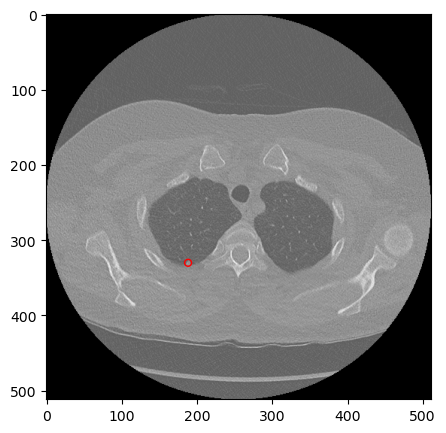

summit-3399-wdd_Y0_BASELINE_A already exists
(0.652344, 0.652344, 0.625)
summit-3399-wdd_Y0_BASELINE_A - x: 66.54, y: 145.35, z: -69.5, d: 18.0 / row: 370, col: 478, idx: 291, scan shape: (420, 512, 512)


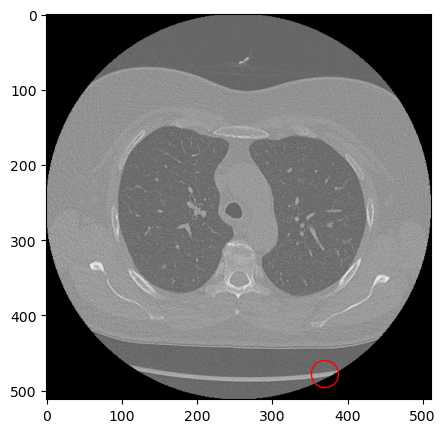

In [171]:

for scan_id in nodules_outside_scan_dims.scan_id.unique():

    md = metadata.query(f'scan_id == "{scan_id}"')
    
    if md.empty:
        print(f'{scan_id} not found in metadata')
        continue

    for i, row in md.iterrows():
    
        copy_scan_from_cluster(scan_id, workspace)
        show_nodule(scan_id, row['nodule_x_coordinate'], row['nodule_y_coordinate'], row['nodule_z_coordinate'], row['nodule_diameter_mm'], workspace)


In [27]:
def copy_npy_from_cluster(scan_id, workspace):
    
    if not Path(f"{workspace}/models/ticnet/cache/preprocessed/{scan_id}.npy").exists():
    
        command = [
            "scp",
            "-P 2222",
            f"jmccabe@localhost:/cluster/project2/SUMMIT/cache/sota/ticnet/summit/preprocessed/{scan_id}.npy",
            f"{workspace}/models/ticnet/cache/preprocessed/."
        ]
        result = subprocess.run(command)
        print(result.stdout)

    if not Path(f"{workspace}/models/ticnet/cache/preprocessed/{scan_id}_bboxes.npy").exists():
        command = [
            "scp",
            "-P 2222",
            f"jmccabe@localhost:/cluster/project2/SUMMIT/cache/sota/ticnet/summit/preprocessed/{scan_id}_bboxes.npy",
            f"{workspace}/models/ticnet/cache/preprocessed/."
        ]
        result = subprocess.run(command)
        print(result.stdout)





for scan_id in list(negative_labels.scan_id.unique())[:1] + list(nodules_outside_scan_dims.scan_id.unique())[:1]:

    print(scan_id)
    copy_npy_from_cluster(scan_id, workspace)
    
    # copy_scan_from_cluster(scan_id, workspace)

    clean = np.load(f'cache/preprocessed/{scan_id}.npy')
    boxes = np.load(f'cache/preprocessed/{scan_id}_bboxes.npy')

    print(clean.squeeze().shape)
    mid_idx = clean.squeeze().shape[0] // 2
    fig, ax = plt.subplots(figsize=(10, 10))


    for box in boxes:
        x, y, z, d = box
        row = int(x)
        col = int(y)
        idx = int(z)
        d = int(d)

        ax.imshow(clean.squeeze()[idx, :, :], cmap='gray')
        circle = plt.Circle((row, col), d, color='r', fill=False)
        ax.add_artist(circle)

        plt.show()
        break

summit-5628-vrn_Y0_BASELINE_A
None


scp: /cluster/project2/SUMMIT/cache/sota/ticnet/summit/preprocessed/summit-5628-vrn_Y0_BASELINE_A_.npy: No such file or directory


None


FileNotFoundError: [Errno 2] No such file or directory: 'cache/preprocessed/summit-5628-vrn_Y0_BASELINE_A_bboxes.npy'